### Part 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

### How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

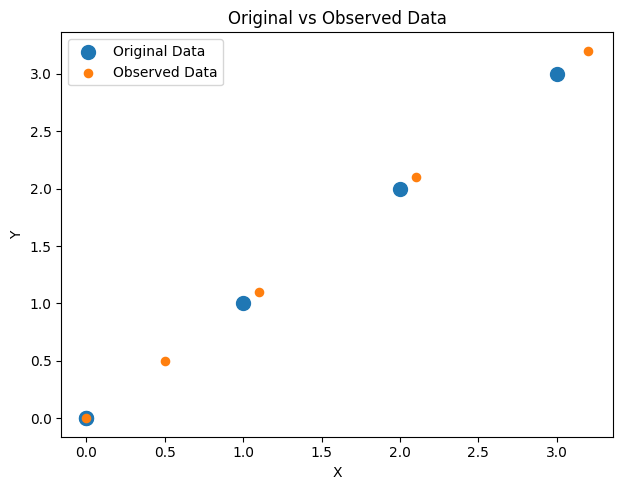

Original: [0. 1. 2. 3. 0.]
Observed [0.  1.1 2.1 3.2 0.5]
Error [ 0.  -0.1 -0.1 -0.2 -0.5]


In [2]:
gt_u = [1.0,1.0,1.0,-3.0,0.0]
ob_u = [1.1,1.0,1.1,-2.7,0.0]

x=np.zeros(len(ob_u))
x[0] = 0

for i in range(1,len(ob_u)):
    x[i] = x[i-1] + ob_u[i-1]

ogx=np.zeros(len(gt_u))
ogx[0] = 0

for i in range(1,len(gt_u)):
    ogx[i] = ogx[i-1] + gt_u[i-1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.title('Original vs Observed Data')
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(ogx,ogx,label='Original Data',s=100)
plt.scatter(x,x,label='Observed Data',s=35)
plt.legend()

plt.tight_layout()
plt.show()

print("Original:",ogx)
print("Observed",np.round(x,5))
print("Error",np.round(ogx-x,5))

In [3]:
om = [100,100,100,100,100,1000]
omega = np.zeros((6,6))
np.fill_diagonal(omega, om) 

def fx(ob_u,x):
    fx0 = []
    for i in range(len(ob_u)-1):
        fx0.append(x[i] + ob_u[i] - x[i+1])
    fx0.append(x[0] + ob_u[len(ob_u)-1] - x[len(ob_u)-1])
    fx0.append(x[0] - 0)
    return fx0

def jacob():
    J = np.zeros((6,5))
    for i in range(4):
        J[i][i] = 1
        J[i][i+1] = -1    
    J[4][0] = 1
    J[4][4] = -1
    J[5][0] = 1
    return J

print("FX(0):\n",fx(ob_u,x))
print("\nJacobian:\n",jacob())
print("\nOmega:\n",omega)

FX(0):
 [0.0, 0.0, 0.0, 0.0, -0.5, 0.0]

Jacobian:
 [[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.]]

Omega:
 [[ 100.    0.    0.    0.    0.    0.]
 [   0.  100.    0.    0.    0.    0.]
 [   0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.  100.    0.    0.]
 [   0.    0.    0.    0.  100.    0.]
 [   0.    0.    0.    0.    0. 1000.]]


In [6]:
def gauss(ob_u,x):
    fx0 = fx(ob_u,x)
    J = jacob()
    H = np.dot(np.dot(J.T,omega),J)
    b = np.dot(np.dot(J.T,omega.T),fx0)
    del_x = np.dot(-b,np.linalg.inv(H))
    return del_x

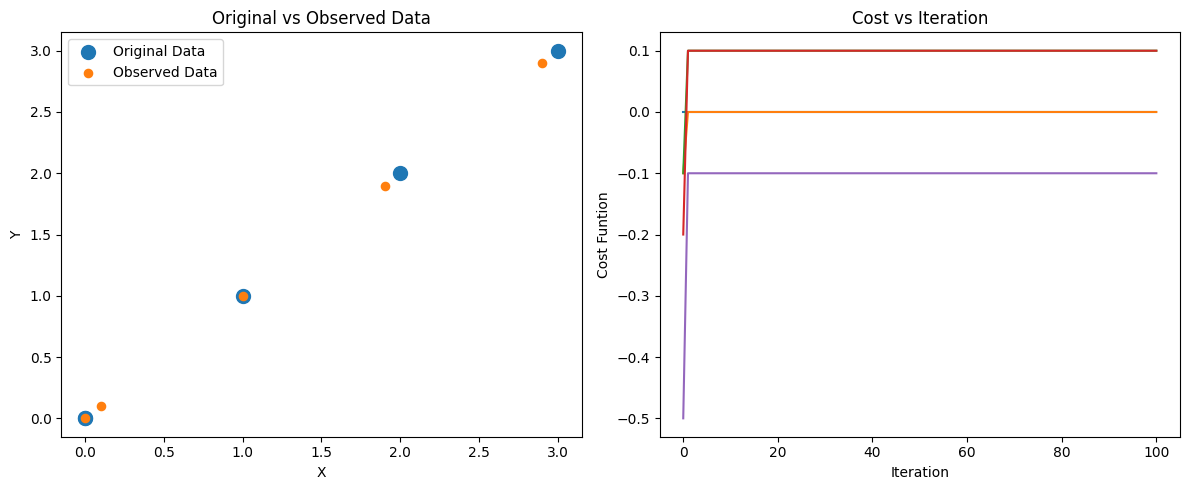

Original: [0. 1. 2. 3. 0.]
Observed [-0.   1.   1.9  2.9  0.1]
Error [ 0.  -0.   0.1  0.1 -0.1]


In [7]:
no_iterations = 100
cost_hist=[]
cost_hist.append(ogx-x)
for i in range(no_iterations):
    del_x = gauss(ob_u,x)
    x = x+del_x
    cost_hist.append(ogx-x)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.title('Original vs Observed Data')
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(ogx,ogx,label='Original Data',s=100)
plt.scatter(x,x,label='Observed Data',s=35)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost Funtion')
plt.plot(range(len(cost_hist)),cost_hist)

plt.tight_layout()
plt.show()

print("Original:",ogx)
print("Observed",np.round(x,5))
print("Error",np.round(ogx-x,5))

In [10]:
import jax.numpy as jnp
from jax import jacfwd

def get_fx2(x):
    f_x=[]
    for i in range(4):
        f_x.append(x[i]+ob_u[i]-x[i+1])
    for i in range(4,5):
        f_x.append(x[0]+ob_u[i]-x[4])
    f_x.append(x[0])
    return jnp.array(f_x)


f = lambda x: get_fx2(x)
J = jacfwd(f)
init=x
verified_jacobian = J(init)
print("Jacobian calculated using JAX")
print(verified_jacobian)


Jacobian calculated using JAX
[[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.]]
